# 대회 개요
* Playground 대회
* 실제 데이터를 바탕으로 합성 데이터를 제공
* 제공된 feature를 바탕으로 소프트웨어 결함 여부를 검출
# 대회 기간
* 시작일 23/10/03
* 종료일 23/10/23
# 평가 지표
* area under the ROC curve
    * `from sklearn.metrics import roc_auc_score`
# 데이터 요약
* feature
    * int와 float형태의 22개의 feature를 제공함
* target
    * defects를 나타내는 boolean 값
        * 결함이 있으면 True
        * 결함이 없으면 False
* feature 정리
    ```
    1. loc              : numeric % McCabe's line count of code
    2. v(g)             : numeric % McCabe "cyclomatic complexity"
    3. ev(g)            : numeric % McCabe "essential complexity"
    4. iv(g)            : numeric % McCabe "design complexity"
    5. n                : numeric % Halstead total operators + operands
    6. v                : numeric % Halstead "volume"
    7. l                : numeric % Halstead "program length"
    8. d                : numeric % Halstead "difficulty"
    9. i                : numeric % Halstead "intelligence"
    10. e               : numeric % Halstead "effort"
    11. b               : numeric % Halstead
    12. t               : numeric % Halstead's time estimator
    13. lOCode          : numeric % Halstead's line count
    14. lOComment       : numeric % Halstead's count of lines of comments
    15. lOBlank         : numeric % Halstead's count of blank lines
    16. lOCodeAndComment: numeric
    17. uniq_Op         : numeric % unique operators
    18. uniq_Opnd       : numeric % unique operands
    19. total_Op        : numeric % total operators
    20. total_Opnd      : numeric % total operands
    21: branchCount     : numeric % of the flow graph
    22. defects         : {false,true} % module has/has not one or more  reported defects
    ```

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
# 데이터 둘러보기

In [39]:
data_path = '../../data/'

train_df = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

In [1]:
# majority class를 minority class의 개수에 맞춰서 downsampling
def downsampling(df):
    df_0 = df[df.defects == 0] # majority class
    df_1 = df[df.defects == 1] # minority class

    idx = list(range(len(df_0)))
    np.random.seed(61)
    np.random.shuffle(idx)
    idx_down = idx[:len(df_1)*2]
    return pd.concat([df_0.iloc[idx_down], df_1])

train_df = downsampling(train_df)
train_df.defects.value_counts()

NameError: name 'train_df' is not defined

In [40]:
# 데이터 요약
def resume_table(df):
    # df = df.drop(columns=target_name)
    summary_df = df.dtypes
    df = df * 1 # defects를 int형으로 바꾸기
    summary_df = summary_df.reset_index()
    summary_df.columns = ['Column', 'Dtypes']
    summary_df['결측치'] = df.isnull().sum().values
    summary_df['유니크개수'] = df.nunique().values
    summary_df['평균'] = df.describe().loc['mean'].values
    summary_df['min'] = df.describe().loc['min'].values
    summary_df['median'] = df.describe().loc['50%'].values
    summary_df['max'] = df.describe().loc['max'].values
    return summary_df.set_index('Column')

resume_table(train_df)

,Dtypes,결측치,유니크개수,평균,min,median,max
Column,,,,,,,
loc,float64,0,378,37.347160,1.0,22.00,3442.00
v(g),float64,0,106,5.492684,1.0,3.00,404.00
ev(g),float64,0,71,2.845022,1.0,1.00,165.00
iv(g),float64,0,84,3.498826,1.0,2.00,402.00
n,float64,0,836,96.655995,0.0,51.00,8441.00
v,float64,0,4515,538.280956,0.0,232.79,80843.08
l,float64,0,55,0.111634,0.0,0.09,1.00
d,float64,0,3360,13.681881,0.0,9.82,418.20
i,float64,0,5171,27.573007,0.0,23.36,569.78


# vif

In [41]:
def vif(x, thresh=10):
    # vif 10 초과시 drop을 위한 임계값 설정
    # Filter method로 feature selection 진행 후 최종 도출 될 데이터 프레임 형성
    output = pd.DataFrame()
    # 데이터의 컬럼 개수 설정
    k = x.shape[1]
    # VIF 측정
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1,k):
        print(f'{i}번째 VIF 측정')
        # VIF 최대 값 선정
        a = np.argmax(vif)
        print(f'Max VIF feature & value : {x.columns[a]}, {vif[a]}')
        # VIF 최대 값이 임계치를 넘지 않는 경우 break
        if (vif[a] <= thresh):
            print('\n')
            for q in range(output.shape[1]):
                print(f'{output.columns[q]}의 vif는 {np.round(vif[q],2)}입니다.')
            break
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        if (i == 1):
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 이후 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        elif (i > 1):
            output = output.drop(output.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

In [42]:
X = train_df.drop(columns='defects')
vif_df = vif(X, 20)

1번째 VIF 측정
Max VIF feature & value : branchCount, 30.62102382338447
2번째 VIF 측정
Max VIF feature & value : total_Opnd, 28.71076448015364
3번째 VIF 측정
Max VIF feature & value : total_Op, 24.843521854143706
4번째 VIF 측정
Max VIF feature & value : n, 17.760236849351767


loc의 vif는 6.67입니다.
v(g)의 vif는 8.11입니다.
ev(g)의 vif는 3.16입니다.
iv(g)의 vif는 4.42입니다.
n의 vif는 17.76입니다.
v의 vif는 13.71입니다.
l의 vif는 1.82입니다.
d의 vif는 11.1입니다.
i의 vif는 8.96입니다.
e의 vif는 3.15입니다.
b의 vif는 12.47입니다.
t의 vif는 3.19입니다.
lOCode의 vif는 13.05입니다.
lOComment의 vif는 1.79입니다.
lOBlank의 vif는 4.53입니다.
locCodeAndComment의 vif는 1.16입니다.
uniq_Op의 vif는 11.07입니다.
uniq_Opnd의 vif는 10.13입니다.


In [43]:
# train_df = train_df[list(vif_df.columns)+['defects']]
# test_df = test_df[list(vif_df.columns)]
# train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

<Axes: >

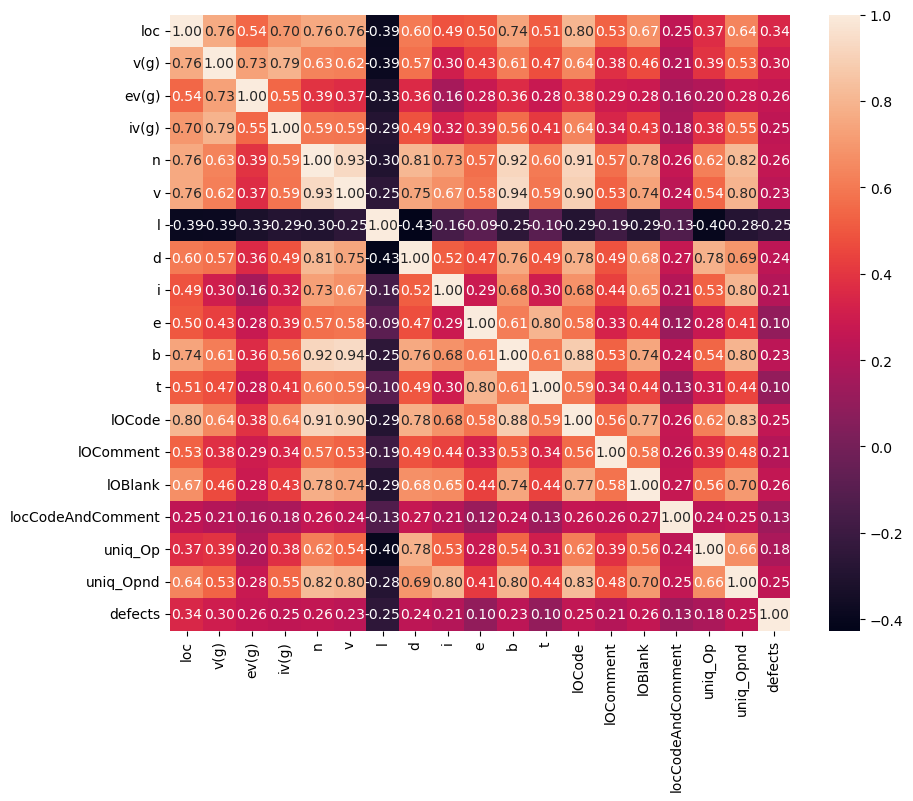

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(data=train_df.corr(), annot=True, fmt='.2f')

# decision tree
## feature importance

In [45]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns='defects')
y = train_df['defects']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=61, stratify=y)

In [46]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, criterion='gini')
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [47]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

# valid Acc
y_pred_valid = model.predict(X_valid)
cm_test = confusion_matrix(y_valid, y_pred_valid)
print('test Confusion Matrix')
print(cm_test)
print(f'test ACC : {(cm_test[0, 0] + cm_test[1, 1]) / cm_test.sum()}')
print(f'test f1-score : {f1_score(y_valid, y_pred_valid)}')
print(f'test roc auc score : {roc_auc_score(y_valid, y_pred_valid)}')

test Confusion Matrix
[[14591  1149]
 [ 2661  1952]]
test ACC : 0.8128040092369675
test f1-score : 0.5060928182525278
test roc auc score : 0.6750766162474924


In [48]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score            Feature
0   0.956414                loc
1   0.016226            lOBlank
2   0.010571          uniq_Opnd
3   0.003264                  l
4   0.002398            uniq_Op
5   0.002331               v(g)
6   0.002205                  i
7   0.002022                  d
8   0.001863                  v
9   0.000858             lOCode
10  0.000733                  e
11  0.000629              iv(g)
12  0.000485                  b
13  0.000000                  t
14  0.000000                  n
15  0.000000  locCodeAndComment
16  0.000000          lOComment
17  0.000000              ev(g)


In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

# new feature

In [50]:
from matplotlib import gridspec

def outlier_score(df, feature, iqr_weight=1.5):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3-q1
    return q3+iqr_weight*iqr


In [51]:
def outlier_count(df1, df2, columns):
    all_df = pd.concat([df1, df2])
    outlier_df = pd.DataFrame(columns=['mix_outlier'])
    is_first_feature = True
    for feature in columns:
        threshold = outlier_score(all_df, feature)
        if is_first_feature:
            outlier_df['mix_outlier'] = all_df[feature].apply(lambda x: 1 if x>threshold else 0).astype(str)+'_'
            is_first_feature=False
        else:
            outlier_df['mix_outlier'] += all_df[feature].apply(lambda x: 1 if x>threshold else 0).astype(str)+'_' # 0_1_1_
    val_counts_dict = outlier_df['mix_outlier'].value_counts().to_dict() #{'0_1_1_':300, '1_1_1_':500}
    outlier_max_val_counts = sorted(val_counts_dict.items(), key = lambda item: item[1], reverse = True)[0][0]
    print(f'가장 빈번하게 출몰하는 outlier : {outlier_max_val_counts}')
    all_df['outlier_count'] = outlier_df['mix_outlier'].apply(lambda x: 0 if x==outlier_max_val_counts else 1)

    return all_df[:df1.shape[0]], all_df[df1.shape[0]:].dropna(axis=1)

In [52]:
from sklearn.preprocessing import OrdinalEncoder

importance_features = feature_map.loc[feature_map['Score']>0.01, 'Feature']
print(f'<importance features>\n{importance_features}')
train_df, test_df = outlier_count(train_df, test_df, importance_features)
train_df.info()

<importance features>
0          loc
1      lOBlank
2    uniq_Opnd
Name: Feature, dtype: object
가장 빈번하게 출몰하는 outlier : 0_0_0_
<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 no

In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67842 entries, 101763 to 169604
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                67842 non-null  float64
 1   v(g)               67842 non-null  float64
 2   ev(g)              67842 non-null  float64
 3   iv(g)              67842 non-null  float64
 4   n                  67842 non-null  float64
 5   v                  67842 non-null  float64
 6   l                  67842 non-null  float64
 7   d                  67842 non-null  float64
 8   i                  67842 non-null  float64
 9   e                  67842 non-null  float64
 10  b                  67842 non-null  float64
 11  t                  67842 non-null  float64
 12  lOCode             67842 non-null  int64  
 13  lOComment          67842 non-null  int64  
 14  lOBlank            67842 non-null  int64  
 15  locCodeAndComment  67842 non-null  int64  
 16  uniq_Op            67

<Axes: xlabel='outlier_count', ylabel='defects'>

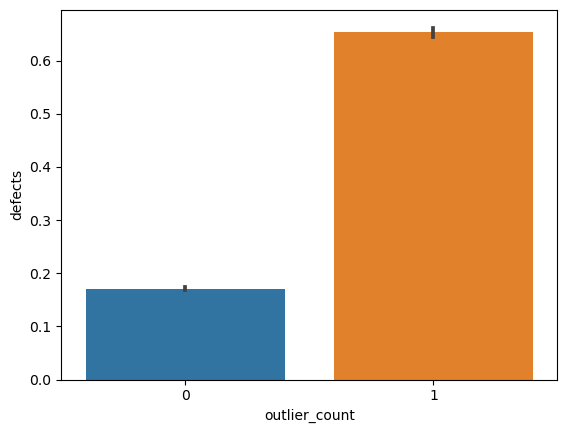

In [54]:
sns.barplot(data=train_df, x='outlier_count', y='defects')

<Axes: xlabel='outlier_count', ylabel='count'>

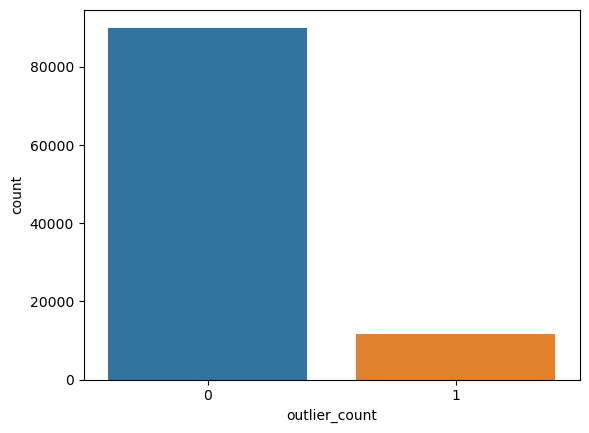

In [55]:
sns.countplot(data=train_df, x='outlier_count')

# outlier 처리

In [56]:
X = train_df.iloc[:, :-1].copy()

In [57]:
def show_outlier(df, y, features):
    plt.figure(figsize=(8,2*len(features)))
    grid = gridspec.GridSpec(len(features),2)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    for idx, feature in enumerate(features):
        threshold = outlier_score(df, feature)

        feature_outlier = (df[feature]>threshold)*1
        ax0 = plt.subplot(grid[idx*2])
        ax1 = plt.subplot(grid[idx*2+1])
        sns.boxplot(data=df, y=feature, ax=ax0)
        sns.barplot(x=feature_outlier, y=y, ax=ax1)

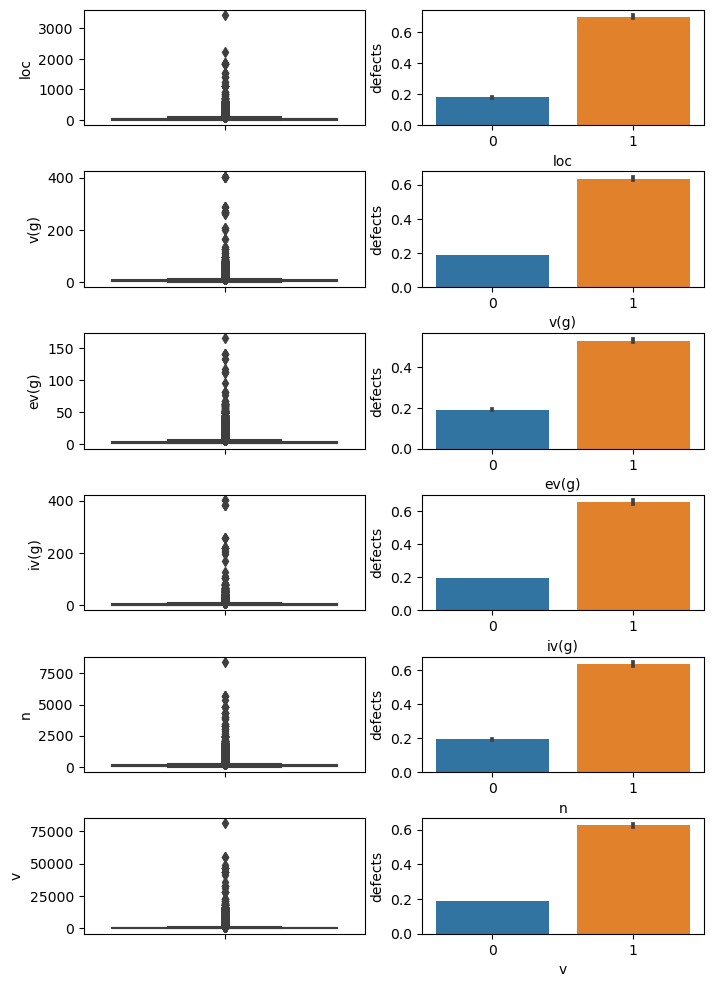

In [58]:
show_outlier(X, train_df['defects'], train_df.columns[:6])

In [59]:
# show_outlier(X, train_df['defects'], train_df.columns[6:12])

In [60]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67842 entries, 101763 to 169604
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                67842 non-null  float64
 1   v(g)               67842 non-null  float64
 2   ev(g)              67842 non-null  float64
 3   iv(g)              67842 non-null  float64
 4   n                  67842 non-null  float64
 5   v                  67842 non-null  float64
 6   l                  67842 non-null  float64
 7   d                  67842 non-null  float64
 8   i                  67842 non-null  float64
 9   e                  67842 non-null  float64
 10  b                  67842 non-null  float64
 11  t                  67842 non-null  float64
 12  lOCode             67842 non-null  int64  
 13  lOComment          67842 non-null  int64  
 14  lOBlank            67842 non-null  int64  
 15  locCodeAndComment  67842 non-null  int64  
 16  uniq_Op            67

In [61]:
def show_outlier(df1, df2, feature_names):
    plt.figure(figsize=(10,2*len(feature_names)))
    grid = gridspec.GridSpec(len(feature_names),2)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    for idx,feature_name in enumerate(feature_names):
        ax0 = plt.subplot(grid[2*idx])
        ax1 = plt.subplot(grid[2*idx+1])
        sns.boxplot(data=df1, y=feature_name, ax=ax0)
        sns.boxplot(data=df2, y=feature_name, ax=ax1)

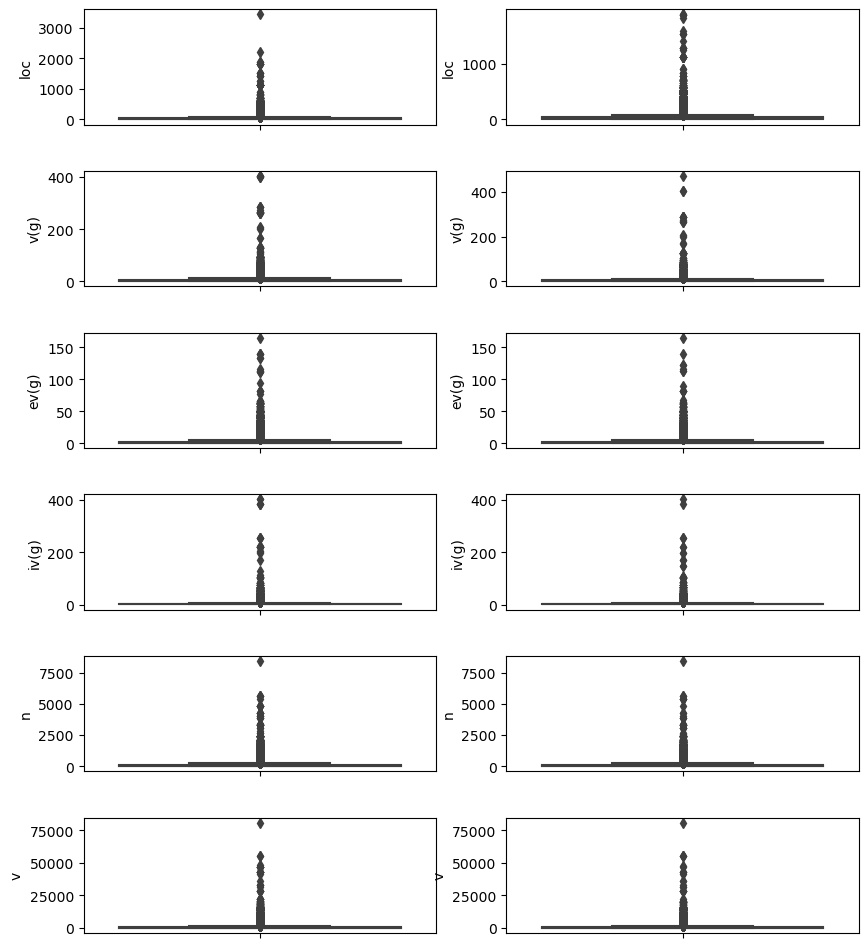

In [62]:
show_outlier(train_df, test_df, train_df.columns[:6])

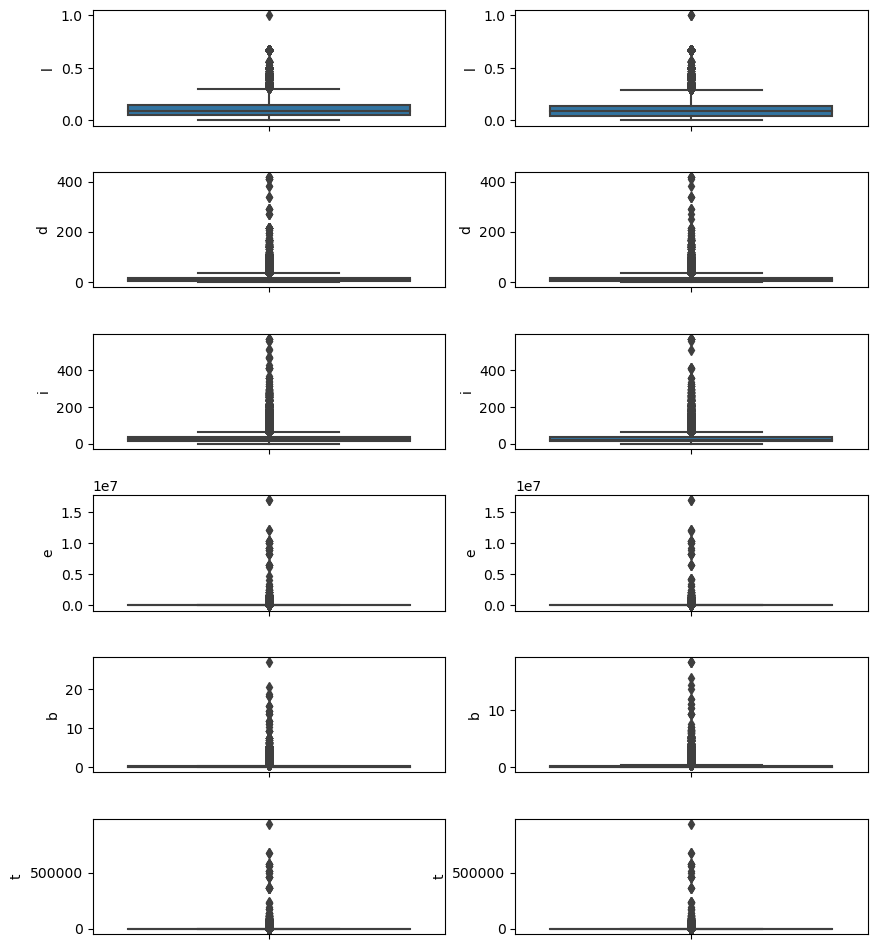

In [63]:
show_outlier(train_df, test_df, train_df.columns[6:12])

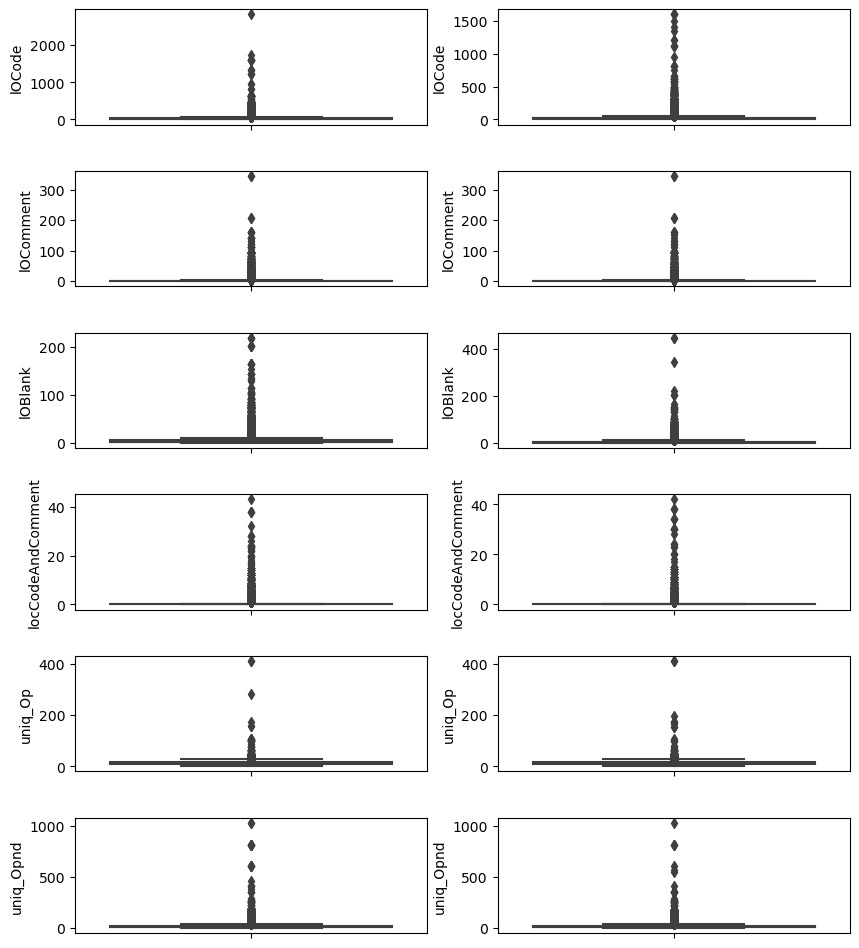

In [64]:
show_outlier(train_df, test_df, train_df.columns[12:18])

<Axes: xlabel='lOBlank', ylabel='defects'>

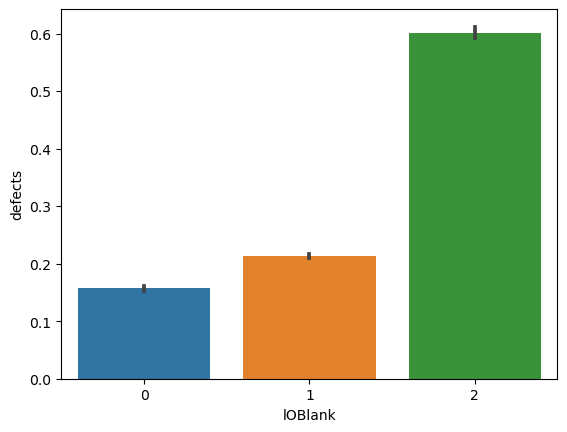

In [65]:
sns.barplot(x=train_df['lOBlank'].apply(lambda l:  0 if l<=1 else 1 if l<10 else 2), y=train_df['defects'])
# sns.histplot(data=train_df, x='lOBlank')

<Axes: xlabel='lOBlank', ylabel='count'>

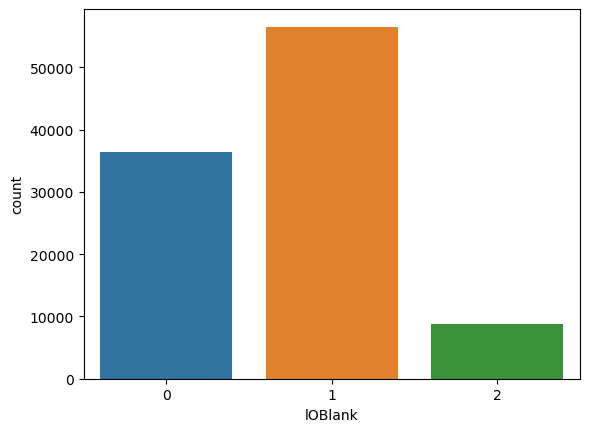

In [66]:
sns.countplot(x=train_df['lOBlank'].apply(lambda l:  0 if l<=1 else 1 if l<10 else 2))

In [67]:
train_df.loc[train_df['lOBlank']!=0, 'lOBlank'].describe()

count    82439.000000
mean         4.912760
std          6.760161
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        219.000000
Name: lOBlank, dtype: float64

In [68]:
train_df['lOBlank'] = train_df['lOBlank'].apply(lambda l:  0 if l<=1 else 1 if l<10 else 2)
test_df['lOBlank'] = test_df['lOBlank'].apply(lambda l:  0 if l<=1 else 1 if l<10 else 2)

In [69]:
mask1 = train_df['loc']>3000
mask2 = train_df['lOCode']>2000
train_df = train_df.drop(train_df[mask1 | mask2].index)

In [70]:
train_df.loc[train_df['b']>20, 'b'] = 20

# ohe

In [71]:
# train_df = pd.get_dummies(train_df, columns=['lOBlank'], drop_first=True, dtype=int)
# test_df = pd.get_dummies(test_df, columns=['lOBlank'], drop_first=True, dtype=int)

# save train & test

In [72]:
train_df.to_csv(data_path+'train_f1.csv')
test_df.to_csv(data_path+'test_f1.csv')